### <h1>Capstone Project - The Battle of Neighborhoods </h1>
Identify most popular areas for hotels in Manhattan for a Hotel Chain who is considering to enter the city.

A hotel chain is looking to open a hotel in Manhattan and want to know which area they should open it and what kind of business concept should be implemented in each cluster. 

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px"　display="block">

1. [Preparing hotel location data in Manhattan](#0)<br>
2. [Getting Foursquare Data for Venue Categories near hotels](#2)<br>
3. [Analyze data - K-means Clustering](#4) <br>
4. [Visualizing Data](#6) <br>
5. [Alanysis](#8) <br>
</div>

<hr>

Import necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
print('Libraries imported.')

Libraries imported.


In [2]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

Libraries imported.


## 1. Preparing Manhattan Neighborhood Data

#### Manhattan Neighborhood Data

Download NY City neighborhoods data that contains boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood.

In [3]:
#Import json data from URL
import urllib.request
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json'
with urllib.request.urlopen(url) as u:
  with open('newyork_data.json', 'bw') as o:
    o.write(u.read())

In [4]:
#Load the json data 
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

# Define a new variable that includes 'features' data.
ny_neighborhoods_data = newyork_data['features']

Tranform the data into a _pandas_ dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
ny_neighborhoods = pd.DataFrame(columns=column_names)

#loop through the data and fill the dataframe one row at a time.
for data in ny_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    ny_neighborhoods = ny_neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
ny_neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Cleanup the data that contains 'Manhattan' in Borough.

In [6]:
neighborhoods = ny_neighborhoods[ny_neighborhoods['Borough']=='Manhattan']

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
6,Manhattan,Marble Hill,40.876551,-73.910660
100,Manhattan,Chinatown,40.715618,-73.994279
101,Manhattan,Washington Heights,40.851903,-73.936900
102,Manhattan,Inwood,40.867684,-73.921210
103,Manhattan,Hamilton Heights,40.823604,-73.949688


## 2. Getting Foursquare Data for Venue Categories in the Neighborhood

Define Foursquare Credentials and Version.

In [17]:
CLIENT_ID = 'IGJQLALW1J5RL4ZE5AXHULRHOWB2G2MY32PLKFKJPUGSKWC4' # your Foursquare ID
CLIENT_SECRET = 'SGGV1A0RB3N3WJUCMTR4L0QITF55UM4FYOF5P2JAJRUG3FOP' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)


Your credentails:
CLIENT_ID: IGJQLALW1J5RL4ZE5AXHULRHOWB2G2MY32PLKFKJPUGSKWC4
CLIENT_SECRET:SGGV1A0RB3N3WJUCMTR4L0QITF55UM4FYOF5P2JAJRUG3FOP


Define get category value function.

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Create a function to repeat the same process to all the neighborhoods.

In [19]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood and create a new dataframe called _all_venues_.

In [20]:
all_venues = getNearbyVenues(neighborhoods['Neighborhood'], neighborhoods['Latitude'],neighborhoods['Longitude'])

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [22]:
ny_venues = all_venues
#ny_venues.to_csv('data/ny_venues.csv')
ny_venues.head()

Create a new dataframe that contains a list of hotels in NY.

In [8]:
#all_hotels = ny_venues[ny_venues['Venue Category']=='Hotel']
#all_hotels.to_csv('data/all_hotels.csv')
all_hotels  = pd.read_csv('data/all_hotels.csv')
all_hotels.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,23,Chinatown,40.715618,-73.994279,Hotel 50 Bowery,40.715936,-73.996789,Hotel
1,466,Upper East Side,40.775639,-73.960508,The Mark Hotel,40.775274,-73.963383,Hotel
2,469,Upper East Side,40.775639,-73.960508,The Carlyle,40.774413,-73.963301,Hotel
3,488,Upper East Side,40.775639,-73.960508,The Surrey,40.774415,-73.963889,Hotel
4,866,Upper West Side,40.787658,-73.977059,The Lucerne Hotel,40.783427,-73.978495,Hotel


In [25]:
#Run getNearbyVenues using Hotel data
all_venues = getNearbyVenues(all_hotels['Venue'], all_hotels['Venue Latitude'],all_hotels['Venue Longitude'])

Hotel 50 Bowery
The Mark Hotel
The Carlyle
The Surrey
The Lucerne Hotel
The Empire Hotel
YOTEL New York
Pod Times Square
Distrikt Hotel
Sofitel New York
Andaz 5th Avenue - a concept by Hyatt
The Algonquin Hotel, Autograph Collection
Bryant Park Hotel
Hyatt Centric Times Square New York
LUMA Hotel Times Square
The Renwick Hotel, Curio Collection by Hilton
The Kitano Hotel New York
The Langham, New York, Fifth Avenue
Hilton Garden Inn
The High Line Hotel
Dream Downtown
Mercer Hotel
Greenwich Hotel
Arlo SoHo
citizenM Bowery
Hotel 50 Bowery
Crosby Street Hotel
Mercer Hotel
Freehand New York
Lex Hotel NYC
Conrad New York Downtown
New York Marriott Downtown
W New York - Downtown
Courtyard by Marriott New York Downtown Manhattan/World Trade Center Area
Holiday Inn Manhattan-Financial District
Residence Inn by Marriott New York Downtown Manhattan/World Trade Center Area
AKA Wall Street
Andaz Wall Street - a concept by Hyatt
The Marmara Manhattan
The Ludlow Hotel
SIXTY LES Hotel
PUBLIC
The Bowe

In [9]:
#Rename column headers of Neighborhood to Hotel
#all_venues.to_csv('data/all_venues.csv')
all_venues  = pd.read_csv('data/all_venues.csv')
all_venues = all_venues.rename(columns={'Neighborhood': 'Hotel', 'Neighborhood Latitude': 'Hotel Latitude', 'Neighborhood Longitude': 'Hotel Longitude'})
all_venues.head()

,Unnamed: 0,Hotel,Hotel Latitude,Hotel Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Hotel 50 Bowery,40.715936,-73.996789,Zu Yuan Spa,40.715469,-73.998627,Spa
1,1,Hotel 50 Bowery,40.715936,-73.996789,Hotel 50 Bowery,40.715936,-73.996789,Hotel
2,2,Hotel 50 Bowery,40.715936,-73.996789,The Original Chinatown Ice Cream Factory,40.715521,-73.998145,Ice Cream Shop
3,3,Hotel 50 Bowery,40.715936,-73.996789,Xi'an Famous Foods,40.715232,-73.997263,Chinese Restaurant
4,4,Hotel 50 Bowery,40.715936,-73.996789,Alimama,40.715854,-73.999139,Dessert Shop


## 3. Analyze Each Hotel's Neighborhood

Plot Number of Hotels in the map of Manhattan in order to analyse which area has more hotels.

### Number of hotels in Neighborhood

In [124]:
#Create a new dataframe with a number of hotels in each neighborhood
hotel_grouped = all_hotels.groupby('Neighborhood').count().reset_index()
hotel_grouped = hotel_grouped.loc[:, ['Neighborhood', 'Venue']] # Use only those two columns
hotel_grouped = hotel_grouped.merge(neighborhoods, on='Neighborhood', how='inner') #Merge with geolocation dataframe
hotel_grouped = hotel_grouped.sort_values('Venue', ascending=False)
hotel_grouped.rename(columns={'Venue': 'No Hotels'}, inplace=True)
hotel_grouped.to_csv('data/hotel_grouped.csv')
hotel_grouped_top = hotel_grouped.head(10)
hotel_grouped_top

,Neighborhood,No Hotels,Borough,Latitude,Longitude
12,Midtown,6,Manhattan,40.754691,-73.981669
13,Midtown South,6,Manhattan,40.748510,-73.988713
0,Battery Park City,5,Manhattan,40.711932,-74.016869
15,Noho,5,Manhattan,40.723259,-73.988434
14,Murray Hill,4,Manhattan,40.748303,-73.978332
4,Civic Center,4,Manhattan,40.715229,-74.005415
9,Hudson Yards,4,Manhattan,40.756658,-74.000111
21,Upper East Side,3,Manhattan,40.775639,-73.960508
5,Clinton,3,Manhattan,40.759101,-73.996119
6,Financial District,3,Manhattan,40.707107,-74.010665


In [39]:
#Set maximum number of hotels for coloring
max_no = hotel_grouped['No Hotels'].max()
max_no

6

### K-Means clustering 

In [11]:
# one hot encoding
all_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
all_onehot['Hotel'] =all_venues['Hotel'] 

# move neighborhood column to the first column
fixed_columns = [all_onehot.columns[-1]] + list(all_onehot.columns[:-1])
all_onehot = all_onehot[fixed_columns]

#Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
all_grouped= all_onehot.groupby('Hotel').mean().reset_index()

In [12]:
all_grouped.head()

,Hotel,Yoga Studio,Accessories Store,Adult Boutique,American Restaurant,Animal Shelter,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Watch Shop,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,AKA Sutton Place,0.00,0.0,0.01,0.03,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.02,0.01,0.0,0.00
1,AKA Wall Street,0.01,0.0,0.00,0.04,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.02,0.0,0.01
2,Ace Hotel New York,0.01,0.0,0.00,0.01,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.01,0.00,0.0,0.00
3,Andaz 5th Avenue - a concept by Hyatt,0.00,0.0,0.00,0.02,0.0,0.0,0.0,0.0,0.01,...,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.00,0.0,0.00
4,Andaz Wall Street - a concept by Hyatt,0.00,0.0,0.00,0.04,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.00


Create a new dataframe that contains top 10 most common venues for analysis

In [13]:
#Definefunction to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']


Conduct a K-Means Elbow method  to run k-means clustering for a range of clusters k (let’s say from 1 to 10) and for each value, we are calculating the sum of squared distances from each point to its assigned center(distortions).

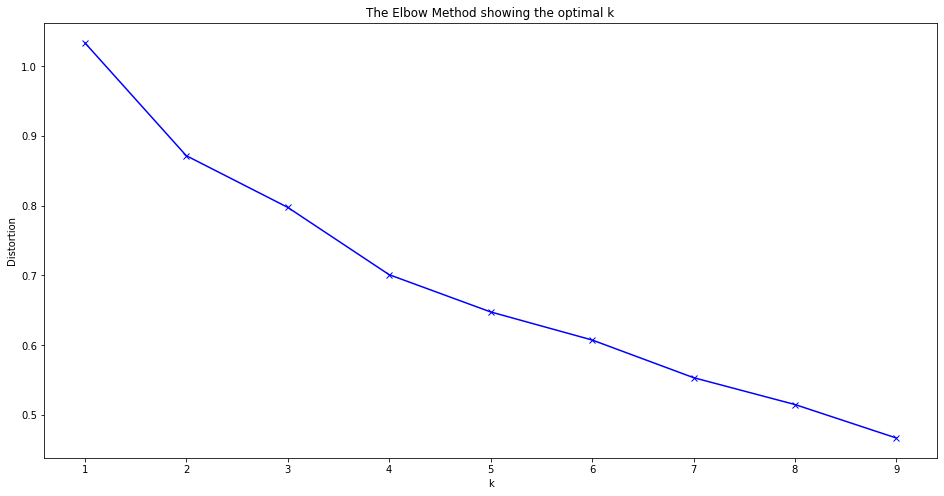

In [22]:
#Running K-Means with a range of k
df = all_grouped.drop('Hotel', 1)  
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df)
    distortions.append(kmeanModel.inertia_)
    
#Plotting the distortions of K-Means
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Run _k_-means to cluster the neighborhood into 8 clusters.

In [164]:
# create columns according to number of top venues
columns = ['Hotel']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Hotel'] = all_grouped['Hotel']

for ind in np.arange(all_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(all_grouped.iloc[ind, :], num_top_venues)

#neighborhoods_venues_sorted.head()

# set number of clusters
kclusters = 8
ninit=1000
randomstate=1

all_grouped_clustering = all_grouped.drop('Hotel', 1)

# run k-means clustering
#kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(all_grouped_clustering)
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=ninit, random_state=randomstate)
kmeans.fit(all_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 4, 0, 1, 4, 3, 1, 1, 4, 4], dtype=int32)

Add clustering labels to neighborhoods data.

In [165]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

#Rename Neighborhood Column into Venue
neighborhoods_venues_sorted = neighborhoods_venues_sorted.rename(columns={'Hotel': 'Venue'})

#Merge data with hotel location data
newyork_merged =all_hotels

# merge all_grouped with manhattan_data to add latitude/longitude for each neighborhood
newyork_merged = all_hotels.merge(neighborhoods_venues_sorted.set_index('Venue'), on='Venue', how='inner').drop('')
newyork_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,Chinatown,40.715618,-73.994279,Hotel 50 Bowery,40.715936,-73.996789,Hotel,5,Chinese Restaurant,Bakery,Dessert Shop,Dim Sum Restaurant,Bubble Tea Shop,Salon / Barbershop,Noodle House,Spa,Vietnamese Restaurant,Shanghai Restaurant
1798,Little Italy,40.719324,-73.997305,Hotel 50 Bowery,40.715936,-73.996789,Hotel,5,Chinese Restaurant,Bakery,Dessert Shop,Dim Sum Restaurant,Bubble Tea Shop,Salon / Barbershop,Noodle House,Spa,Vietnamese Restaurant,Shanghai Restaurant
466,Upper East Side,40.775639,-73.960508,The Mark Hotel,40.775274,-73.963383,Hotel,7,Exhibit,Coffee Shop,Cosmetics Shop,Outdoor Sculpture,American Restaurant,Italian Restaurant,Art Museum,Bakery,Park,Café
469,Upper East Side,40.775639,-73.960508,The Carlyle,40.774413,-73.963301,Hotel,7,Italian Restaurant,Coffee Shop,Cosmetics Shop,Boutique,Outdoor Sculpture,Exhibit,Park,French Restaurant,Café,Clothing Store
488,Upper East Side,40.775639,-73.960508,The Surrey,40.774415,-73.963889,Hotel,7,Italian Restaurant,Coffee Shop,Exhibit,Art Museum,Cosmetics Shop,Outdoor Sculpture,Boutique,Clothing Store,Park,French Restaurant


## 4. Visualizing Data

#### Use geopy library to get the latitude and longitude values of New York City and Toront.

In [40]:
#Obtain geolocation data of New York City
ny_address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode(ny_address)
ny_latitude =ny_location.latitude
ny_longitude = ny_location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(ny_latitude, ny_longitude))


The geograpical coordinate of New York are 40.7896239, -73.9598939.


In [166]:
from folium.features import DivIcon
# Plot Manhattan 
ny_map_nh = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=13) 

# add markers to the map

for lat, lon, poi, cluster in zip(hotel_grouped['Latitude'],hotel_grouped['Longitude'], hotel_grouped['Neighborhood'], hotel_grouped['No Hotels']):
    text = str(poi) + '(' + str(cluster) +  ')' 
    folium.CircleMarker(
        [lat, lon],
        radius=3 * cluster,
        color='black',
        weight=1,
        fill=False
    ).add_to(ny_map_nh)
    
    folium.Marker(
    [lat, lon],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size:10pt;line-height:0.8; width: 60px;margin-left:-20px;margin-top:-20px:text-align:center">%s</div>' % text,
        )
    ).add_to(ny_map_nh)


In [167]:
# Plot 1: Manhattan Neighborhoods with number of hotels
ny_map_nh

## Plot Clusters

In [225]:
# Plot Manhattan
ny_map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=12, ) 

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_merged['Venue Latitude'],newyork_merged['Venue Longitude'], newyork_merged['Venue'], newyork_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(ny_map_clusters)
for lat, lon, poi, cluster in zip(hotel_grouped_top['Latitude'],hotel_grouped_top['Longitude'], hotel_grouped_top['Neighborhood'], hotel_grouped_top['No Hotels']):
    text = str(poi) + '(' + str(cluster) +  ')' 
    folium.CircleMarker(
        [lat, lon],
        radius=5 * cluster,
        color = 'black',
        weight=1,
        fill=False
    ).add_to(ny_map_clusters)
    
    folium.Marker(
    [lat, lon],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size:10pt;line-height:0.8; width: 60px;margin-left:-20px;margin-top:-20px:text-align:center">%s</div>' % text,
        )
    ).add_to(ny_map_clusters)    


In [226]:
# Plot 1: New York City
ny_map_clusters

Create a list of hotels in top areas for detailed analysis.

In [219]:
#Rename column to merge dataframes
df = hotel_grouped_top.merge(newyork_merged.drop(columns=newyork_merged.columns[[1,2,4,5,6]], axis=1), on='Neighborhood')
hotels_sorted_top = df.drop(columns=df.columns[[2,3,4]], axis=1)
hotels_sorted_top.head()

,Neighborhood,No Hotels,Venue,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Midtown,6,Sofitel New York,1,Theater,Clothing Store,Bakery,Steakhouse,Sushi Restaurant,Plaza,Sporting Goods Shop,Bookstore,American Restaurant,Coffee Shop
1,Midtown,6,Andaz 5th Avenue - a concept by Hyatt,1,Bakery,Coffee Shop,Clothing Store,Sporting Goods Shop,Mediterranean Restaurant,Grocery Store,Steakhouse,Bookstore,Sushi Restaurant,Café
2,Midtown,6,"The Algonquin Hotel, Autograph Collection",1,Theater,Clothing Store,Bakery,Sporting Goods Shop,Bookstore,Steakhouse,American Restaurant,Plaza,Coffee Shop,Sushi Restaurant
3,Midtown,6,Bryant Park Hotel,1,Bakery,Clothing Store,Sandwich Place,Café,Theater,American Restaurant,Gym / Fitness Center,Coffee Shop,Steakhouse,Mediterranean Restaurant
4,Midtown,6,Hyatt Centric Times Square New York,2,Theater,Cosmetics Shop,Bookstore,Cuban Restaurant,Italian Restaurant,Sushi Restaurant,Plaza,Steakhouse,Bakery,Toy / Game Store


In [240]:
hotels_sorted_top.to_csv('data/hotels_sorted_top.csv')

## 5. Analysis

Examine  cluster and determine the discriminating venue categories that distinguish each cluster.

<h4>Summary:</h4>
By conducting k-mean clustering of each hotel, 6 areas categorized 3 groups were identified:

<h4>Group 1:  Theater area</h4>
<li>Area 1: Cluster 1 in Midtown and Murray Hill (Purple)</li>
<li>Area 2: Cluster 1 in Hudson Yards and Clinton (Purple)</li>
<li>Area 3: Cluster 2 in Midtown and Clinton (Blue)</li>

<h4>Group 2: Food area</h4>
<li>Area 4: Cluster 0 in Midtown South and Murray Hill (Red)</li>
<li>Area 5: Cluster 3 in Noho (Light Blue)</li>

<h4>Group 3: Park and exhibit area</h4>
<li>Area 6: Cluster 4 in Battery Park City,  Financial District and Civic Center(Light Green)</li>
<li>Area 7: Cluster 7 in Upper East Side (Orange)</li>


### Group 1: Theater area

#### Area 1 - Cluster 1 in Midtown and Murray Hill (Purple)

This area is located near Theater and there are retail stores such as clothing, books or grocery.

In [232]:
# Area 1 - Midtown and Murray Hill in Cluster 1
hotels_sorted_top.loc[((hotels_sorted_top['Neighborhood'] == 'Midtown') | (hotels_sorted_top['Neighborhood'] == 'Murray Hill'))& ((hotels_sorted_top['Cluster Labels'] == 1)),hotels_sorted_top.columns[[0] + list(range(3,hotels_sorted_top.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Midtown,1,Theater,Clothing Store,Bakery,Steakhouse,Sushi Restaurant,Plaza,Sporting Goods Shop,Bookstore,American Restaurant,Coffee Shop
1,Midtown,1,Bakery,Coffee Shop,Clothing Store,Sporting Goods Shop,Mediterranean Restaurant,Grocery Store,Steakhouse,Bookstore,Sushi Restaurant,Café
2,Midtown,1,Theater,Clothing Store,Bakery,Sporting Goods Shop,Bookstore,Steakhouse,American Restaurant,Plaza,Coffee Shop,Sushi Restaurant
3,Midtown,1,Bakery,Clothing Store,Sandwich Place,Café,Theater,American Restaurant,Gym / Fitness Center,Coffee Shop,Steakhouse,Mediterranean Restaurant
22,Murray Hill,1,Coffee Shop,Japanese Restaurant,Bakery,American Restaurant,Sandwich Place,Gym,Gourmet Shop,Burger Joint,Café,Sushi Restaurant
23,Murray Hill,1,Bakery,Gym / Fitness Center,Sandwich Place,Coffee Shop,Japanese Restaurant,Spa,Restaurant,Gourmet Shop,Bar,American Restaurant


#### Area 2: Cluster 1 in Hudson Yards and Clinton (Purple)

This area is located near Theater and Gym/Fitness Center, Spa and eating place but not retail stores.

In [236]:
# Area 2: Cluster 2 in Hudson Yards and Clinton (Purple)
hotels_sorted_top.loc[((hotels_sorted_top['Neighborhood'] == 'Hudson Yards') | (hotels_sorted_top['Neighborhood'] == 'Clinton'))& ((hotels_sorted_top['Cluster Labels'] == 1)),hotels_sorted_top.columns[[0] + list(range(3,hotels_sorted_top.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Hudson Yards,1,Theater,Gym / Fitness Center,American Restaurant,Coffee Shop,Wine Shop,Sandwich Place,Cocktail Bar,Italian Restaurant,French Restaurant,Spa
31,Hudson Yards,1,Park,Art Gallery,American Restaurant,Coffee Shop,Theater,Cocktail Bar,Grocery Store,Lounge,Gym / Fitness Center,Café
32,Hudson Yards,1,Italian Restaurant,Gym / Fitness Center,Gym,American Restaurant,Thai Restaurant,Furniture / Home Store,Coffee Shop,Burger Joint,Art Gallery,Park
33,Hudson Yards,1,Theater,Gym / Fitness Center,Coffee Shop,American Restaurant,Gym,Italian Restaurant,Spa,Sandwich Place,Ethiopian Restaurant,Dive Bar
37,Clinton,1,Theater,Gym / Fitness Center,American Restaurant,Coffee Shop,Wine Shop,Sandwich Place,Cocktail Bar,Italian Restaurant,French Restaurant,Spa


#### Area 3: Cluster 2 in Midtown and Clinton (Blue)

In [239]:
# Area 3: Cluster 2 in Midtown and Clinton (Blue)
hotels_sorted_top.loc[((hotels_sorted_top['Neighborhood'] == 'Midtown') | (hotels_sorted_top['Neighborhood'] == 'Clinton'))& ((hotels_sorted_top['Cluster Labels'] == 2)),hotels_sorted_top.columns[[0] + list(range(3,hotels_sorted_top.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Midtown,2,Theater,Cosmetics Shop,Bookstore,Cuban Restaurant,Italian Restaurant,Sushi Restaurant,Plaza,Steakhouse,Bakery,Toy / Game Store
5,Midtown,2,Theater,Bakery,Steakhouse,Coffee Shop,Cuban Restaurant,Mediterranean Restaurant,Salad Place,Plaza,Cosmetics Shop,Toy / Game Store
38,Clinton,2,Theater,Italian Restaurant,Burger Joint,American Restaurant,Gym / Fitness Center,Bakery,Sandwich Place,Coffee Shop,Thai Restaurant,Park
39,Clinton,2,Theater,Dance Studio,Coffee Shop,Gym / Fitness Center,Italian Restaurant,Indie Theater,Bakery,Burger Joint,Thai Restaurant,Pizza Place


### Group 2: Food area

#### Area 4 - Cluster 0 in Midtown South and Murray Hill (Red)

Korean restaurants and eating place.

In [231]:
# Area 4 - Midtown South and Murray Hill 
hotels_sorted_top.loc[((hotels_sorted_top['Neighborhood'] == 'Midtown South') | (hotels_sorted_top['Neighborhood'] == 'Murray Hill'))& ((hotels_sorted_top['Cluster Labels'] == 0)),hotels_sorted_top.columns[[0] + list(range(3,hotels_sorted_top.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Midtown South,0,Korean Restaurant,Café,Dessert Shop,Spa,Gym / Fitness Center,New American Restaurant,Cosmetics Shop,Coffee Shop,Bakery,Japanese Restaurant
7,Midtown South,0,Korean Restaurant,Café,Coffee Shop,Hotel Bar,Dessert Shop,New American Restaurant,Lounge,Spa,Gym / Fitness Center,Italian Restaurant
8,Midtown South,0,Korean Restaurant,Coffee Shop,Gym / Fitness Center,Hotel Bar,Café,Japanese Restaurant,Dessert Shop,Italian Restaurant,Bar,Bakery
9,Midtown South,0,Korean Restaurant,Coffee Shop,Italian Restaurant,Café,Japanese Restaurant,New American Restaurant,Sandwich Place,Gym / Fitness Center,Hotel Bar,American Restaurant
11,Midtown South,0,Korean Restaurant,Bakery,Japanese Restaurant,Coffee Shop,Cosmetics Shop,Mediterranean Restaurant,Fried Chicken Joint,Café,Sandwich Place,Bookstore
24,Murray Hill,0,Korean Restaurant,Bakery,Coffee Shop,American Restaurant,Gym / Fitness Center,Japanese Restaurant,Steakhouse,Vegetarian / Vegan Restaurant,Fried Chicken Joint,Cuban Restaurant
25,Murray Hill,0,Korean Restaurant,Café,Spa,Bar,Gym / Fitness Center,Italian Restaurant,Japanese Restaurant,Bakery,Salad Place,Pizza Place


#### Area 5: Cluster 3 in Noho

Mainly restaurants and coffee shops especially Italian and Mexican restaurants.

In [235]:
# Area 5: Cluster 3 in Noho
hotels_sorted_top.loc[((hotels_sorted_top['Neighborhood'] == 'Noho'))& ((hotels_sorted_top['Cluster Labels'] == 3)),hotels_sorted_top.columns[[0] + list(range(3,hotels_sorted_top.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,Noho,3,Mexican Restaurant,Italian Restaurant,Coffee Shop,French Restaurant,Sandwich Place,Wine Shop,Bookstore,Café,Bakery,Vietnamese Restaurant
18,Noho,3,Mexican Restaurant,Sandwich Place,Italian Restaurant,French Restaurant,Coffee Shop,Bakery,Ice Cream Shop,Pizza Place,Cocktail Bar,Yoga Studio
19,Noho,3,Italian Restaurant,Bookstore,Coffee Shop,Cocktail Bar,Japanese Restaurant,French Restaurant,Cosmetics Shop,Wine Shop,Sandwich Place,Bakery
20,Noho,3,Italian Restaurant,Bar,American Restaurant,Coffee Shop,Yoga Studio,Sushi Restaurant,Art Gallery,Japanese Restaurant,Pizza Place,Mexican Restaurant
21,Noho,3,Café,Cocktail Bar,Coffee Shop,Italian Restaurant,Pizza Place,Ice Cream Shop,Mediterranean Restaurant,Cosmetics Shop,Rock Club,Jewelry Store


### Group 3: Park and exhibit area

#### Area 6 -  Cluster 4 in Battery Park City,  Financial District and Civic Center (Light Green)

Coffee Shops and Parks, Sandwich Places

In [234]:
# Area 3: Area 6 -  Cluster 4 in Battery Park City,  Financial District and Civic Center (Light Green)
hotels_sorted_top.loc[((hotels_sorted_top['Neighborhood'] == 'Battery Park City') | (hotels_sorted_top['Neighborhood'] == 'Financial District')|(hotels_sorted_top['Neighborhood'] == 'Civic Center'))& ((hotels_sorted_top['Cluster Labels'] == 4)),hotels_sorted_top.columns[[0] + list(range(3,hotels_sorted_top.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Battery Park City,4,Park,Coffee Shop,Playground,Burger Joint,Deli / Bodega,Memorial Site,Gym,Food Court,Sandwich Place,Steakhouse
13,Battery Park City,4,Park,Coffee Shop,Memorial Site,Gym,Pizza Place,Gourmet Shop,Plaza,Gym / Fitness Center,Café,Shopping Mall
14,Battery Park City,4,Coffee Shop,Park,Pizza Place,Memorial Site,Gourmet Shop,Sandwich Place,Ice Cream Shop,Bar,Falafel Restaurant,Plaza
15,Battery Park City,4,Coffee Shop,Pizza Place,Memorial Site,Gym / Fitness Center,Clothing Store,Sandwich Place,Gourmet Shop,Shopping Mall,Park,Monument / Landmark
16,Battery Park City,4,Park,Coffee Shop,Pizza Place,Memorial Site,Mexican Restaurant,Clothing Store,Steakhouse,Gym,Gourmet Shop,Café
27,Civic Center,4,Coffee Shop,Sandwich Place,Café,Gym,Memorial Site,American Restaurant,Shopping Mall,Gym / Fitness Center,Falafel Restaurant,Pizza Place
28,Civic Center,4,Sandwich Place,Coffee Shop,Gym,Wine Shop,Pizza Place,Falafel Restaurant,Deli / Bodega,Plaza,Italian Restaurant,Indian Restaurant
40,Financial District,4,Coffee Shop,Pizza Place,Memorial Site,Park,Sandwich Place,Jewelry Store,Clothing Store,Café,Gym / Fitness Center,Wine Shop
41,Financial District,4,Coffee Shop,American Restaurant,Pizza Place,Falafel Restaurant,Steakhouse,Sandwich Place,Juice Bar,Café,Jewelry Store,Park
42,Financial District,4,Coffee Shop,Cocktail Bar,American Restaurant,Salad Place,Gym,Bar,Falafel Restaurant,Mexican Restaurant,Gym / Fitness Center,Steakhouse


#### Area 7: Cluster 7 in Upper East Side (Orange)

Exhibit and Art Museum

In [237]:
# Area 7: Cluster 7 in Upper East Side (Orange)
hotels_sorted_top.loc[((hotels_sorted_top['Neighborhood'] == 'Upper East Side'))& ((hotels_sorted_top['Cluster Labels'] == 7)),hotels_sorted_top.columns[[0] + list(range(3,hotels_sorted_top.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Upper East Side,7,Exhibit,Coffee Shop,Cosmetics Shop,Outdoor Sculpture,American Restaurant,Italian Restaurant,Art Museum,Bakery,Park,Café
35,Upper East Side,7,Italian Restaurant,Coffee Shop,Cosmetics Shop,Boutique,Outdoor Sculpture,Exhibit,Park,French Restaurant,Café,Clothing Store
36,Upper East Side,7,Italian Restaurant,Coffee Shop,Exhibit,Art Museum,Cosmetics Shop,Outdoor Sculpture,Boutique,Clothing Store,Park,French Restaurant
